**Predicting 2024 Duke Home Football Attendance**

*with prior seasons' home attendance data.*

This document uses a random forest model to attempt to predict Duke home-game football attendance.

-----

Authors: Calvin Chen, Victor Barbosa Slivinskis

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load the dataset
data = pd.read_csv('data/DukeAttendanceV8_HomeOnly_pastData.csv')

print(data)

print(data.dtypes)

                OppName  Year  OppFPI  DukeFPI  FPI_diff  DukeFPI_NetChange  \
0           Florida St.  2001     NaN      NaN       NaN                NaN   
1          Northwestern  2001     NaN      NaN       NaN                NaN   
2          Georgia Tech  2001     NaN      NaN       NaN                NaN   
3           Wake Forest  2001     NaN      NaN       NaN                NaN   
4            Vanderbilt  2001     NaN      NaN       NaN                NaN   
..                  ...   ...     ...      ...       ...                ...   
136        Northwestern  2023     0.8      8.9      -8.1                3.7   
137          Notre Dame  2023    22.1      8.9      13.2                3.7   
138  North Carolina St.  2023     7.3      8.9      -1.6                3.7   
139         Wake Forest  2023    -1.7      8.9     -10.6                3.7   
140          Pittsburgh  2023    -0.5      8.9      -9.4                3.7   

     OppFPI_PrevYear  FPI_Diff_PrevYear  Site  Mont

In [7]:
# ALL FEATURES:
# Select relevant columns
refined_data = data[['Year', 'OppFPI_PrevYear', 'FPI_Diff_PrevYear', 'Month', 'Date', 'OnSaturday', 'OnFriday', 
                     'Start_Time', 'After_COVID', 'Renovated', 'UNC_Game', 'First_Game', 'First_Home_Game', 
                     'Elko', 'Cutcliffe', 'NC_Opponent', 'OppCityDist', 'AttNum']]

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
refined_data = pd.DataFrame(imputer.fit_transform(refined_data), columns=refined_data.columns)

# Define features and target
y = refined_data['AttNum']
X = refined_data.drop('AttNum', axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# FEATURE SUBSET:
# Select relevant columns
refined_data = data[['Year', 'OppFPI_PrevYear', 
                     'Start_Time', 'After_COVID', 'UNC_Game', 'First_Game', 'First_Home_Game', 
                     'Cutcliffe', 'NC_Opponent', 'OppCityDist', 'AttNum']]

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
refined_data = pd.DataFrame(imputer.fit_transform(refined_data), columns=refined_data.columns)

# Define features and target
y = refined_data['AttNum']
X = refined_data.drop('AttNum', axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Mean Absolute Error: 4496.332461077403
Mean Squared Error: 36203289.90150256
R² Score: 0.29437512662215426


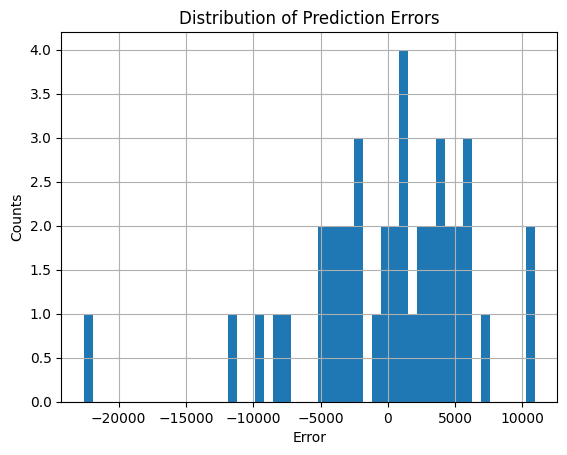


Importance of each feature used in the model:
OppCityDist: 0.39951594433730747
Year: 0.20588388442490413
Cutcliffe: 0.11007539197213084
Start_Time: 0.10067518735283588
OppFPI_PrevYear: 0.08200263910691728
After_COVID: 0.07019990248967294
First_Home_Game: 0.01596538535291594
UNC_Game: 0.007187696432805732
First_Game: 0.004943078382398904
NC_Opponent: 0.003550890148110854


Correlation matrix of the dataframe, showing the Pearson correlation coefficients between each pair of features:
AttNum             1.000000
Start_Time         0.365919
UNC_Game           0.341124
Cutcliffe          0.340467
NC_Opponent        0.261891
OppFPI_PrevYear    0.187290
First_Game         0.182771
First_Home_Game    0.172795
Year               0.171926
OppCityDist        0.169005
After_COVID        0.158330
Name: AttNum, dtype: float64


Features ranked via RFE:
[(1, 'OppCityDist'), (2, 'Year'), (3, 'Start_Time'), (4, 'Cutcliffe'), (5, 'OppFPI_PrevYear'), (6, 'After_COVID'), (7, 'First_Home_Game'), (8, 'UNC

In [10]:
# Create a Random Forest Regressor
#model = RandomForestRegressor(n_estimators=100, random_state=42)
model = RandomForestRegressor(bootstrap = True, max_depth = 20, min_samples_leaf = 1, min_samples_split = 10, n_estimators = 500)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

results = y_pred - y_test
unique, counts = np.unique(results, return_counts=True)

# Plot residuals
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1, 1, 1)
ax.hist(results, bins=50)
ax.set(xlabel='Error', ylabel='Counts',
       title='Distribution of Prediction Errors')
ax.grid(True)
plt.show()

# Feature Importances
print("\nImportance of each feature used in the model:")
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
for idx in sorted_indices:
    print(f"{X.columns[idx]}: {feature_importances[idx]}")

# Correlation matrix of the dataframe
print("\n\nCorrelation matrix of the dataframe, showing the Pearson correlation coefficients between each pair of features:")
correlation_matrix = refined_data.corr()
target_correlation = correlation_matrix['AttNum'].abs().sort_values(ascending=False)
print(target_correlation)

# Features ranked via RFE
from sklearn.feature_selection import RFE
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X.columns))
print("\n\nFeatures ranked via RFE:")
print(ranked_features)

# Features ranked via ANOVA F-value
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), selector.scores_), X.columns))
print("\n\nFeatures ranked via ANOVA F-value:")
print(ranked_features)

In [178]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000]
    #'max_depth': [None, 10, 20, 30, 40, 50, 60],
    #'min_samples_split': [2, 4, 6, 8, 10, 12],
    #'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    #'max_features': ['sqrt', 'log2', 2, 4, 5, 6, 8]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best parameters to train the final model
best_model = RandomForestRegressor(**best_params, bootstrap = True, max_depth = 20, min_samples_leaf = 1, min_samples_split = 10, random_state=42)
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 500}
Mean Absolute Error: 4476.833397102238
Mean Squared Error: 35644573.91860656
R² Score: 0.3052648522729937


**TEST USING POLYNOMIAL FEATURES:**

Mean Absolute Error: 4298.4784554052785
Mean Squared Error: 36263505.06941673
R² Score: 0.2932014951552223


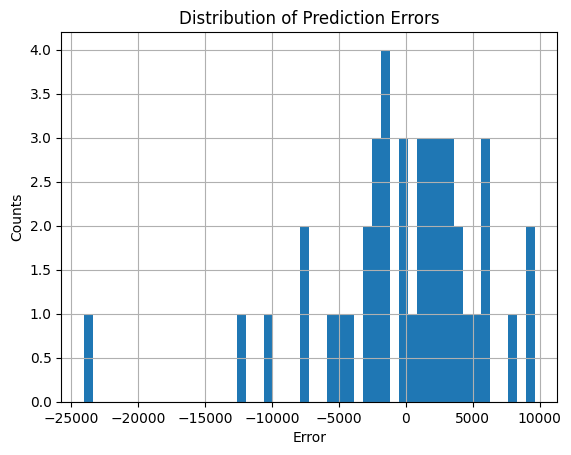


Importance of each feature used in the model:
Start_Time OppCityDist: 0.2030216729704975
Cutcliffe OppCityDist: 0.10449223769348139
Year OppCityDist: 0.08642708750273168
OppCityDist^2: 0.0773424601241541
Year Start_Time: 0.05846793517157222
Start_Time Cutcliffe: 0.05727929090157561
After_COVID OppCityDist: 0.04893563529933332
OppCityDist: 0.0477458505433128
Year^2: 0.04028267028362625
Start_Time After_COVID: 0.0362707209755256
Year: 0.0335593283365821
OppFPI_PrevYear Cutcliffe: 0.025094587986898165
Year OppFPI_PrevYear: 0.023500251691528723
OppFPI_PrevYear OppCityDist: 0.021721167577884105
Year Cutcliffe: 0.021444908944938116
OppFPI_PrevYear After_COVID: 0.016931093951857597
OppFPI_PrevYear Start_Time: 0.015978669294729356
OppFPI_PrevYear^2: 0.011339582482229372
Year UNC_Game: 0.00666805061682311
OppFPI_PrevYear: 0.00641854168410377
Start_Time: 0.006297353538872977
OppFPI_PrevYear First_Home_Game: 0.006241406636596736
Year NC_Opponent: 0.004690928037666864
After_COVID: 0.0045902450301

In [159]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a Random Forest Regressor
model = RandomForestRegressor(bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100)

# Train the model
model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred = model.predict(X_test_poly)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Residuals
results = y_pred - y_test
unique, counts = np.unique(results, return_counts=True)

# Plot residuals
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1, 1, 1)
ax.hist(results, bins=50)
ax.set(xlabel='Error', ylabel='Counts', title='Distribution of Prediction Errors')
ax.grid(True)
plt.show()

# Feature Importances
print("\nImportance of each feature used in the model:")
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
for idx in sorted_indices:
    print(f"{poly.get_feature_names_out()[idx]}: {feature_importances[idx]}")

# Correlation matrix of the dataframe
print("\nCorrelation matrix of the dataframe, showing the Pearson correlation coefficients between each pair of features:")
correlation_matrix = refined_data.corr()
target_correlation = correlation_matrix['AttNum'].abs().sort_values(ascending=False)
print(target_correlation)

# Features ranked via RFE
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train_poly, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), poly.get_feature_names_out()))
print("\nFeatures ranked via RFE:")
print(ranked_features)

# Features ranked via ANOVA F-value
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train_poly, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), selector.scores_), poly.get_feature_names_out()))
print("\nFeatures ranked via ANOVA F-value:")
print(ranked_features)


**TEST PIPELINE TO AUTOMATICALLY CALCULATE BEST FEATURE TRANSFORMATIONS:**

In [143]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Choose relevant features
refined_data = data[['Year', 'OppFPI_PrevYear', 
                     'Start_Time', 'After_COVID', 'UNC_Game', 'First_Game', 'First_Home_Game', 
                     'Cutcliffe', 'NC_Opponent', 'OppCityDist', 'AttNum']]

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
refined_data = pd.DataFrame(imputer.fit_transform(refined_data), columns=refined_data.columns)

# Define features and target
y = refined_data['AttNum']
X = refined_data.drop('AttNum', axis=1)

# Create a pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),  # Scale features for better performance
    ('selector', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))),
    ('model', RandomForestRegressor(n_estimators=1000, random_state=42))
])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid search for hyperparameters
param_grid = {
    # Define hyperparameters for RandomForestRegressor
    'model__n_estimators': [100, 500, 1000],
    'model__max_depth': [None, 10, 50, 100]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


Mean Absolute Error: 4404.80911410285
Mean Squared Error: 40573403.00266392
R² Score: 0.12407222091757242
